# DistilBERT Detector Analysis

Comprehensive diagnostics for the fine-tuned DistilBERT RAID classifier. Loads the saved checkpoint, scores a held-out split, and examines behavior across metrics, domains, representations, and explainability cues.

In [1]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "src").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))
PROJECT_ROOT

PosixPath('/home/erikhbj/Documents/tdt13/TDT13_AI_text_prediction')

In [36]:
import math
import textwrap

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.calibration import calibration_curve
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (
    auc,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    roc_curve,
)
from sklearn.preprocessing import StandardScaler
from transformers import AutoModelForSequenceClassification, AutoTokenizer

from raid.utils import load_data
import matplotlib.colors as mcolors
from IPython.display import HTML


from src import config
from src import data as data_module
from src.models.perplexity_classifier import PerplexityLogisticClassifier


In [3]:
sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 110
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["axes.labelsize"] = 11

## Configuration

In [4]:
DATA_LIMIT = None  # e.g., 8000 for a lightweight run
SAMPLE_SEED = 42
TEST_RATIO = 0.02
INCLUDE_ADVERSARIAL = config.DEFAULT_INCLUDE_ADVERSARIAL

MODEL_PATH = Path("../models/distilbert-full-split002")
BATCH_SIZE = 32
MAX_LENGTH = 512
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PPL_CLASSIFIER_PATH = Path("../models/perplexity-logistic/perplexity_classifier.pkl")

np.random.seed(SAMPLE_SEED)


## Load RAID split

In [5]:
raw_df = load_data(split="train", include_adversarial=INCLUDE_ADVERSARIAL)
if DATA_LIMIT is not None:
    if DATA_LIMIT <= 0:
        raise ValueError("DATA_LIMIT must be positive or None.")
    raw_df = raw_df.sample(n=min(DATA_LIMIT, len(raw_df)), random_state=SAMPLE_SEED).reset_index(drop=True)

raw_texts = raw_df[data_module.TEXT_SOURCE_COLUMN]
labels_series = data_module._extract_labels(raw_df)  # type: ignore[attr-defined]
valid_mask = raw_texts.notna()
filtered = raw_df.loc[valid_mask].copy()
filtered["text"] = raw_texts.loc[valid_mask].astype(str)
filtered["label"] = labels_series.loc[valid_mask].astype(int)

train_df, test_df = data_module._train_test_split(  # type: ignore[attr-defined]
    filtered,
    test_ratio=TEST_RATIO,
    seed=SAMPLE_SEED,
)
analysis_df = test_df.reset_index(drop=True).copy()
analysis_df["label_name"] = analysis_df["label"].map({0: "Human", 1: "AI"})
analysis_df["char_len"] = analysis_df["text"].str.len()
print(f"Train size: {len(train_df):,} | Test size: {len(analysis_df):,}")
print("Columns available:", list(analysis_df.columns))


Train size: 458,625 | Test size: 9,360
Columns available: ['id', 'adv_source_id', 'source_id', 'model', 'decoding', 'repetition_penalty', 'attack', 'domain', 'title', 'prompt', 'generation', 'text', 'label', 'label_name', 'char_len']


## Load fine-tuned transformer

In [6]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
model.to(DEVICE)
model.eval()
num_layers = model.config.num_hidden_layers
print(f"Model loaded on {DEVICE} with {num_layers} layers.")


Model loaded on cuda with 6 layers.


## Batched inference and representation capture

In [7]:
def batched_predict(texts, batch_size=BATCH_SIZE):
    logits, probs, preds = [], [], []
    cls_embeddings = []
    layer_norm_sums = {0: np.zeros(num_layers), 1: np.zeros(num_layers)}
    layer_counts = {0: 0, 1: 0}

    for start in range(0, len(texts), batch_size):
        batch_texts = texts[start : start + batch_size]
        encoded = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=MAX_LENGTH,
            return_tensors="pt",
        )
        encoded = {k: v.to(DEVICE) for k, v in encoded.items()}
        with torch.no_grad():
            outputs = model(**encoded, output_hidden_states=True)
        batch_logits = outputs.logits.cpu().numpy()
        batch_probs = torch.softmax(outputs.logits, dim=-1)[:, 1].cpu().numpy()
        batch_preds = (batch_probs >= 0.5).astype(int)
        logits.append(batch_logits[:, 1])
        probs.append(batch_probs)
        preds.append(batch_preds)
        cls_emb = outputs.hidden_states[-1][:, 0, :].cpu().numpy()
        cls_embeddings.append(cls_emb)

        for layer_idx in range(1, num_layers + 1):
            layer_cls = outputs.hidden_states[layer_idx][:, 0, :].detach().cpu()
            norms = torch.linalg.norm(layer_cls, dim=-1).numpy()
            for label in (0, 1):
                mask = batch_preds == label
                if mask.any():
                    layer_norm_sums[label][layer_idx - 1] += norms[mask].sum()
                    layer_counts[label] += mask.sum()

    logits = np.concatenate(logits)
    probs = np.concatenate(probs)
    preds = np.concatenate(preds)
    cls_embeddings = np.concatenate(cls_embeddings)
    return logits, probs, preds, cls_embeddings, layer_norm_sums, layer_counts


In [8]:
texts = analysis_df["text"].tolist()
logits, probs, preds, cls_embeddings, layer_norm_sums, layer_counts = batched_predict(texts)
analysis_df["logit"] = logits
analysis_df["prob"] = probs
analysis_df["pred"] = preds
analysis_df["pred_name"] = analysis_df["pred"].map({0: "Human", 1: "AI"})
analysis_df["error_type"] = np.where(
    analysis_df["pred"] == analysis_df["label"],
    "Correct",
    np.where(analysis_df["pred"] == 1, "False Positive", "False Negative"),
)
analysis_df["token_count"] = tokenizer(texts, truncation=True, max_length=MAX_LENGTH, return_length=True)["length"]


## Surface features

In [9]:
def compute_surface_features(text: str) -> tuple[float, float, float]:
    tokens = [tok for tok in text.split() if tok.strip()]
    if not tokens:
        return 0.0, 0.0, 0.0
    avg_len = float(np.mean([len(tok) for tok in tokens]))
    unique = len({tok.lower() for tok in tokens})
    ttr = unique / len(tokens)
    digit_ratio = sum(tok.isdigit() for tok in tokens) / len(tokens)
    return avg_len, ttr, digit_ratio

surface = analysis_df["text"].apply(compute_surface_features)
analysis_df[["avg_word_len", "type_token_ratio", "digit_ratio"]] = pd.DataFrame(surface.tolist(), index=analysis_df.index)
analysis_df.head()


,id,adv_source_id,source_id,model,decoding,repetition_penalty,attack,domain,title,prompt,...,char_len,logit,prob,pred,pred_name,error_type,token_count,avg_word_len,type_token_ratio,digit_ratio
0,2df8825a-2356-4b55-8ded-b246c31a5c92,2df8825a-2356-4b55-8ded-b246c31a5c92,4a9beaa2-84f5-498b-92d9-935107c550b0,chatgpt,greedy,no,none,books,Personal Injuries,Write the body of a plot summary for a novel t...,...,1306,6.332073,0.999991,1,AI,Correct,260,5.079070,0.674419,0.000000
1,56ddff7a-532b-4c56-858f-cd4a27b62695,56ddff7a-532b-4c56-858f-cd4a27b62695,25fef5f2-90c7-4f9c-9cfb-6caff6c69359,llama-chat,greedy,no,none,reddit,WMR constantly goes into sleep mode even when ...,"Write just the body of a Reddit post titled ""W...",...,672,6.328466,0.999992,1,AI,Correct,161,4.868421,0.745614,0.000000
2,762ecae0-9a0e-4207-a217-01da39451e60,762ecae0-9a0e-4207-a217-01da39451e60,ff71deab-4af9-4712-9a32-c46477997857,mpt,sampling,yes,none,poetry,Rudyard Kipling Parody Writers Real Mirror Ref...,The following is the full text of a poem title...,...,2706,6.343088,0.999991,1,AI,Correct,488,5.888041,0.974555,0.000000
3,0bdf2ff9-b0c8-447b-8177-d1a686dc3782,0bdf2ff9-b0c8-447b-8177-d1a686dc3782,87fb4135-4456-4276-bfdc-05ee75825a27,gpt2,sampling,no,none,books,Arundhati,The following is the full text of a plot summa...,...,2034,6.126586,0.999990,1,AI,Correct,482,4.767045,0.590909,0.002841
4,e47640bf-74e4-4c7a-8071-fd8012da79c8,e47640bf-74e4-4c7a-8071-fd8012da79c8,c568b816-b63e-4969-9a57-99d4c072e0b6,mistral,greedy,no,none,abstracts,WAYLA - Generating Images from Eye Movements,The following is the full text of the abstract...,...,2127,6.331082,0.999992,1,AI,Correct,452,4.725067,0.183288,0.000000


### Performance snapshot

In [10]:
report = classification_report(analysis_df["label"], analysis_df["pred"], output_dict=True)
report_df = pd.DataFrame(report).T
print("DistilBERT metrics:")
display(report_df[["precision", "recall", "f1-score"]])
cm = confusion_matrix(analysis_df["label"], analysis_df["pred"])
print("Confusion matrix (rows=truth, cols=pred):")
print(cm)


DistilBERT metrics:


,precision,recall,f1-score
0,0.929825,0.794007,0.856566
1,0.993977,0.998240,0.996104
accuracy,0.992415,0.992415,0.992415
macro avg,0.961901,0.896124,0.926335
weighted avg,0.992147,0.992415,0.992124


Confusion matrix (rows=truth, cols=pred):
[[ 212   55]
 [  16 9077]]


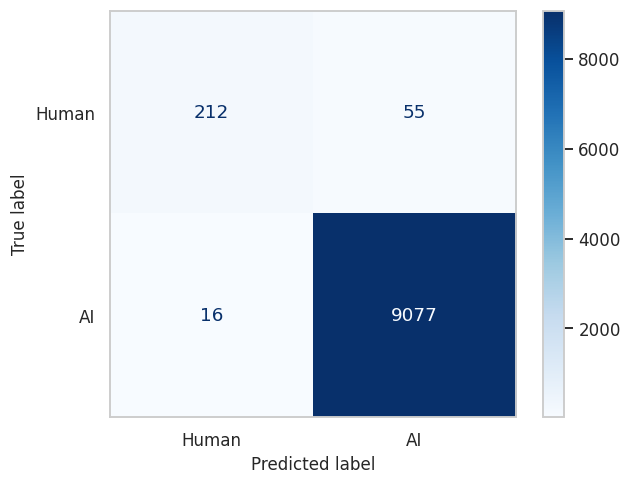

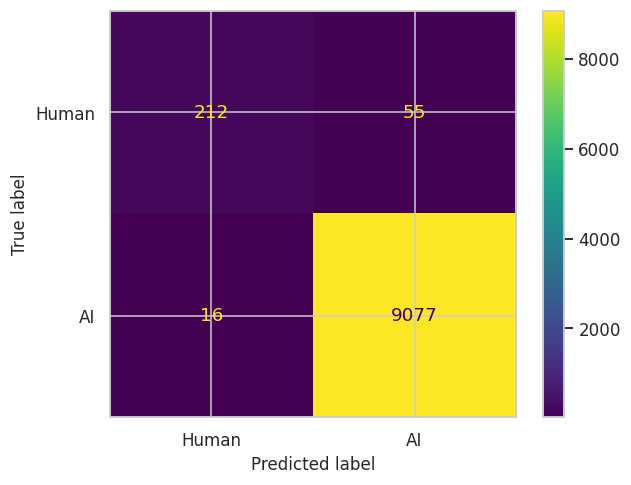

In [44]:
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Human", "AI"]).plot(cmap="Blues")

# Method 1: Use plt.grid(False) before displaying
plt.grid(False) # This needs to be called before disp.plot()
fig, ax = plt.subplots()
disp.plot(ax=ax)
plt.show()

## 1. Score distributions

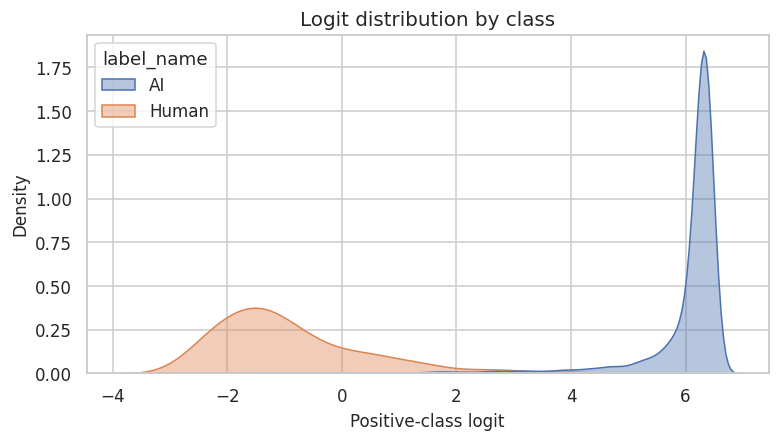

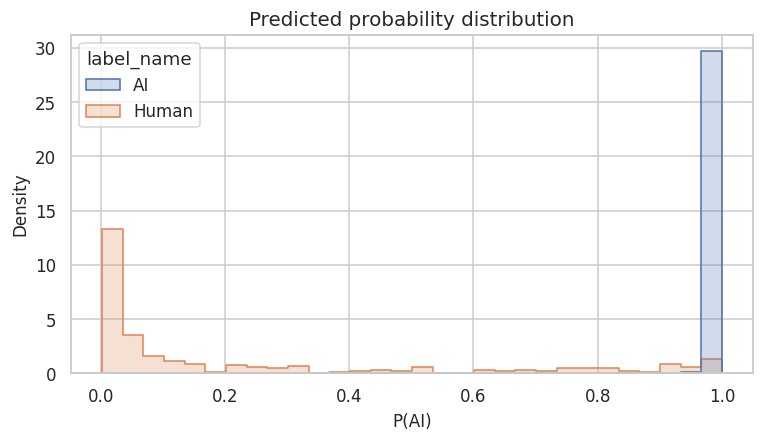

In [11]:
plt.figure(figsize=(8, 4))
sns.kdeplot(data=analysis_df, x="logit", hue="label_name", fill=True, alpha=0.4, common_norm=False)
plt.title("Logit distribution by class")
plt.xlabel("Positive-class logit")
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(data=analysis_df, x="prob", hue="label_name", bins=30, stat="density", element="step", common_norm=False)
plt.title("Predicted probability distribution")
plt.xlabel("P(AI)")
plt.show()


## 2. Calibration & thresholds

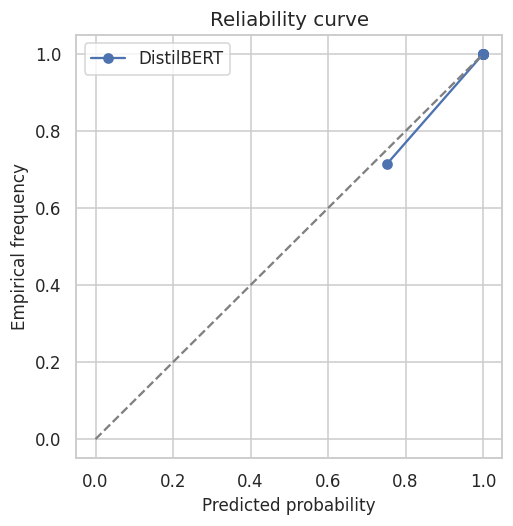

In [12]:
prob_true, prob_pred = calibration_curve(analysis_df["label"], analysis_df["prob"], n_bins=10, strategy="quantile")
plt.figure(figsize=(5, 5))
plt.plot(prob_pred, prob_true, marker="o", label="DistilBERT")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("Predicted probability")
plt.ylabel("Empirical frequency")
plt.title("Reliability curve")
plt.legend()
plt.show()


## 3. ROC & PR curves

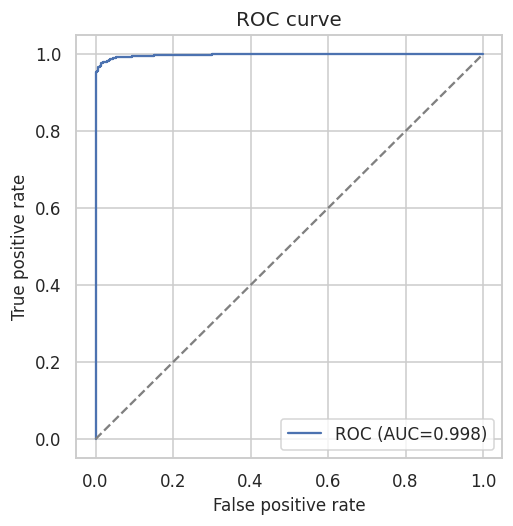

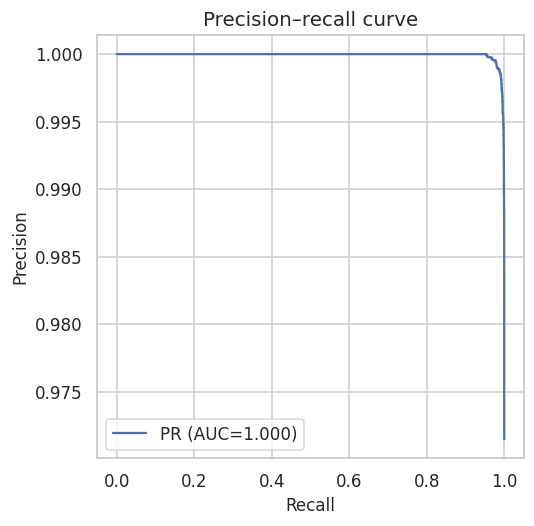

In [13]:
fpr, tpr, _ = roc_curve(analysis_df["label"], analysis_df["prob"])
precision, recall, _ = precision_recall_curve(analysis_df["label"], analysis_df["prob"])
roc_auc = auc(fpr, tpr)
pr_auc = auc(recall, precision)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.legend()
plt.show()

plt.figure(figsize=(5, 5))
plt.plot(recall, precision, label=f"PR (AUC={pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–recall curve")
plt.legend()
plt.show()


## 4. Domain & generator diagnostics

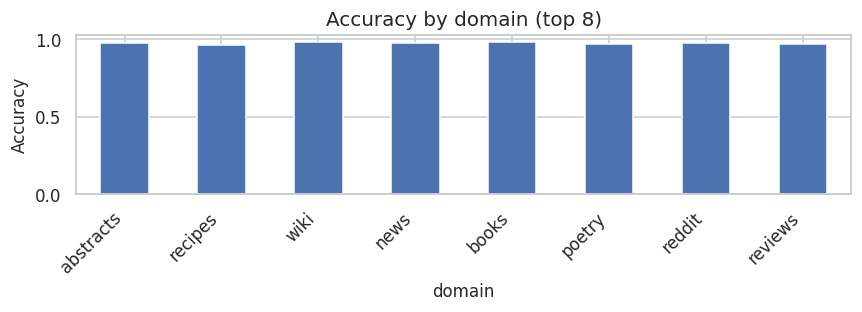

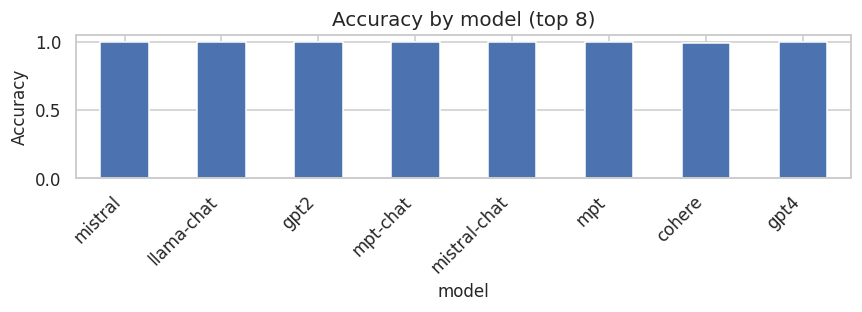

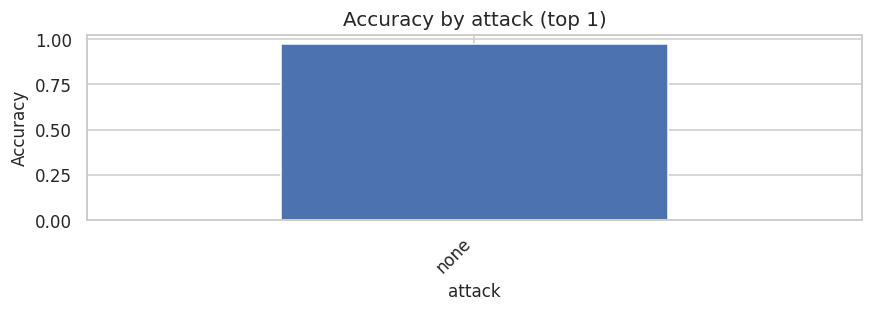

In [14]:
meta_cols = [col for col in ["domain", "generator", "model", "attack", "source_dataset"] if col in analysis_df.columns]
if not meta_cols:
    print("No metadata columns available for slicing.")
else:
    for col in meta_cols:
        subset = analysis_df.copy()
        subset[col] = subset[col].fillna("unknown")
        top_vals = subset[col].value_counts().head(8).index
        plot_df = subset[subset[col].isin(top_vals)]
        pivot = plot_df.groupby(col)["pred"].mean().reindex(top_vals)
        plt.figure(figsize=(8, 3))
        pivot.plot(kind="bar")
        plt.ylabel("Accuracy")
        plt.title(f"Accuracy by {col} (top {len(top_vals)})")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()


## 5. Length & bias checks

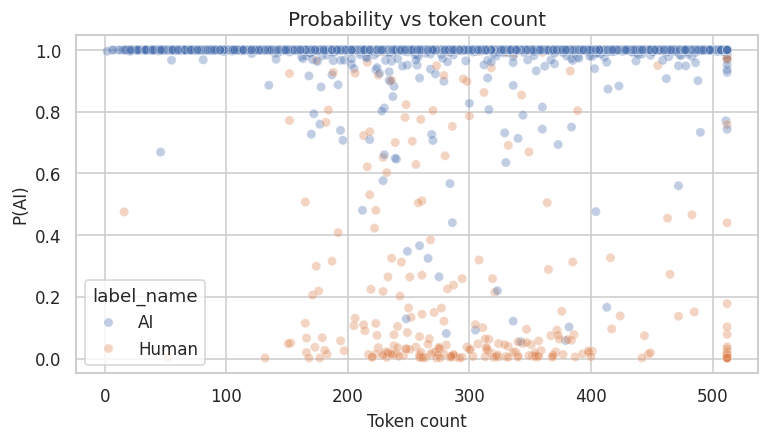

In [15]:
plt.figure(figsize=(8, 4))
sns.scatterplot(data=analysis_df, x="token_count", y="prob", hue="label_name", alpha=0.35)
plt.title("Probability vs token count")
plt.xlabel("Token count")
plt.ylabel("P(AI)")
plt.show()


## 6. CLS embedding projection

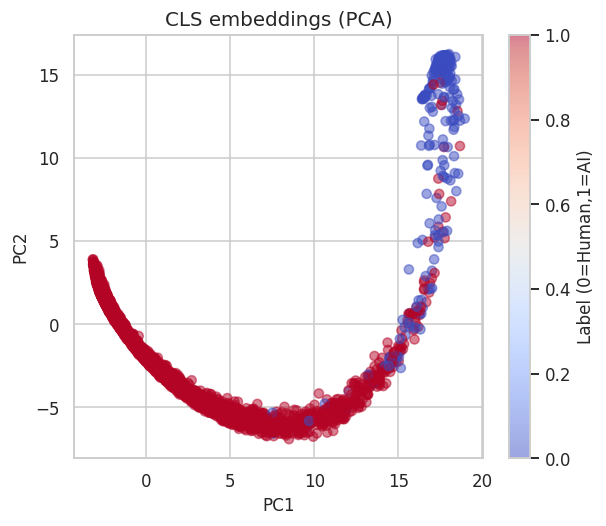

In [16]:
pca = PCA(n_components=2)
cls_pca = pca.fit_transform(cls_embeddings)
plt.figure(figsize=(6, 5))
scatter = plt.scatter(cls_pca[:, 0], cls_pca[:, 1], c=analysis_df["label"], cmap="coolwarm", alpha=0.5)
plt.title("CLS embeddings (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label="Label (0=Human,1=AI)")
plt.show()


## 7. Feature correlations

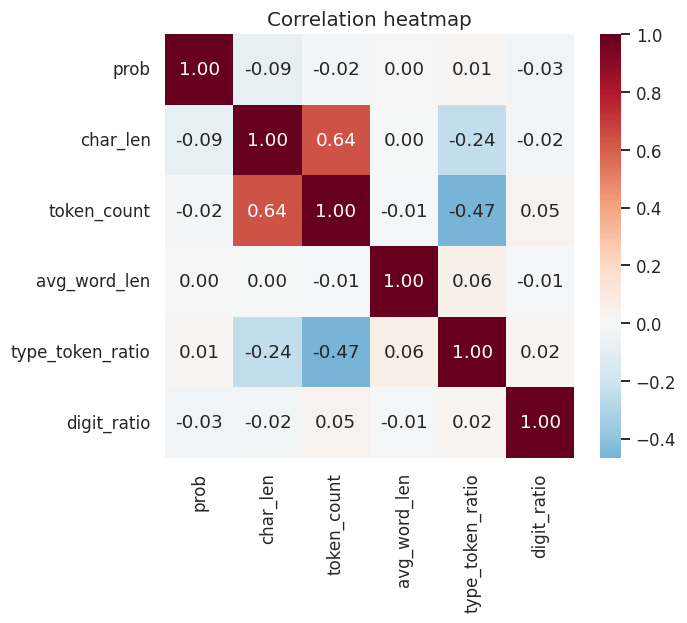

In [17]:
corr_features = analysis_df[["prob", "char_len", "token_count", "avg_word_len", "type_token_ratio", "digit_ratio"]]
corr = corr_features.corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0)
plt.title("Correlation heatmap")
plt.show()


## 8. Error forensics

In [18]:
errors = analysis_df[analysis_df["error_type"] != "Correct"].copy()
print(f"Total errors: {len(errors)} ({len(errors)/len(analysis_df):.1%})")
if errors.empty:
    print("No misclassifications.")
else:
    cols = ["label_name", "pred_name", "prob", "logit", "token_count"]
    if "domain" in errors.columns:
        cols.append("domain")
    display(errors[cols].head(10))
    sample = errors.sort_values("prob", ascending=False).iloc[0]
    print("High-confidence error sample:")
    print(f"ID={sample.name} | Label={sample['label_name']} | Pred={sample['pred_name']} | P(AI)={sample['prob']:.3f}")
    print(textwrap.fill(sample["text"], width=100))


Total errors: 71 (0.8%)


,label_name,pred_name,prob,logit,token_count,domain
79,AI,Human,0.476277,-0.022224,404,news
260,Human,AI,0.862480,0.895051,312,poetry
266,Human,AI,0.602346,0.219339,232,abstracts
491,Human,AI,0.994785,2.697058,282,reddit
585,AI,Human,0.058343,-1.147164,379,reddit
938,Human,AI,0.987295,2.231695,337,news
1247,Human,AI,0.669807,0.344416,349,abstracts
1278,Human,AI,0.752398,0.527876,286,poetry
1471,Human,AI,0.998741,3.459597,425,reviews
1774,Human,AI,0.897846,1.061244,298,poetry


High-confidence error sample:
ID=3143 | Label=Human | Pred=AI | P(AI)=1.000
7.3/10? Seriously? Most mediocre MCU films get a better rating than that. This movie is up there
with The Dark Knight as one of the best superhero movies. This movie was loved when it came out, now
it's cool to hate on the trilogy. Spider-Man 2 improved on all aspects of Spider-Man 1. Peter is
struggling to be Spider-Man, and the movie illustrates that very well. The action is better than
lots of movies today, most notably the train fight scene. Danny Elfman provides an unforgettable
soundtrack. This movie and the trilogy shouldn't be overlooked as some cheesy 2000s movies, because
they paved the way for the MCU as we know it today.


## 9. Attention visualization (sample)

In [47]:
def print_attention_text(sample_idx: int, sample_title: str = ""):
    sample_text = analysis_df.loc[sample_idx, "text"]
    inputs = tokenizer(sample_text, return_tensors="pt", truncation=True, max_length=MAX_LENGTH)
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
    with torch.no_grad():
        attn_outputs = model(**inputs, output_attentions=True)
    attn = attn_outputs.attentions[-1].mean(dim=1).squeeze(0).cpu().numpy()  # (seq_len, seq_len)
    # seq_len = min(40, attn.shape[0])
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][:])
    
    cls_row = attn[0, :len(tokens)]
    # Build per-token colors (skip specials)
    norm = mcolors.Normalize(vmin=float(cls_row.min()),
    vmax=float(cls_row.max()))

    # Make custom transparent-to-red colormap
    c_start = mcolors.colorConverter.to_rgba('white', alpha=0.0)
    c_end = mcolors.colorConverter.to_rgba('red', alpha=1.0)
    cmap = mcolors.LinearSegmentedColormap.from_list(
        'transparent_to_red', [c_start, c_end], 512
    )

    segments = []
    for tok, weight in zip(tokens, cls_row):
        if tok in tokenizer.all_special_tokens:
            continue
        rgba = cmap(norm(float(weight)))
        color = mcolors.to_hex(rgba)
        clean_tok = tok.replace("▁", " ").replace("##", "")
        if not clean_tok.strip():
            continue
        segments.append((clean_tok, color))

    # Wrap tokens into lines (~80 characters per line)
    max_chars = 110
    lines, current, count = [], [], 0
    for token, color in segments:
        length = len(token) + 1
        if count + length > max_chars and current:
            lines.append(current)
            current, count = [], 0
        current.append((token, color))
        count += length
    if current:
        lines.append(current)

    fig_height = max(1.5, 0.45 * len(lines))
    fig, ax = plt.subplots(figsize=(11, fig_height))
    ax.axis("off")
    y_base = len(lines)
    for row, line in enumerate(lines):
        x = 0
        for token, color in line:
            ax.text(
                x,
                y_base - row,
                token,
                fontsize=11,
                ha="left",
                va="center",
                bbox=dict(facecolor=color, edgecolor="none",
    boxstyle="round,pad=0.1", alpha=0.9),
            )
            x += len(token) + 1.5
    ax.set_xlim(0, max_chars)
    ax.set_ylim(0, len(lines) + 1)
    plt.title(f"CLS attention heatmap as text - {sample_title}")
    plt.tight_layout()
    plt.show()

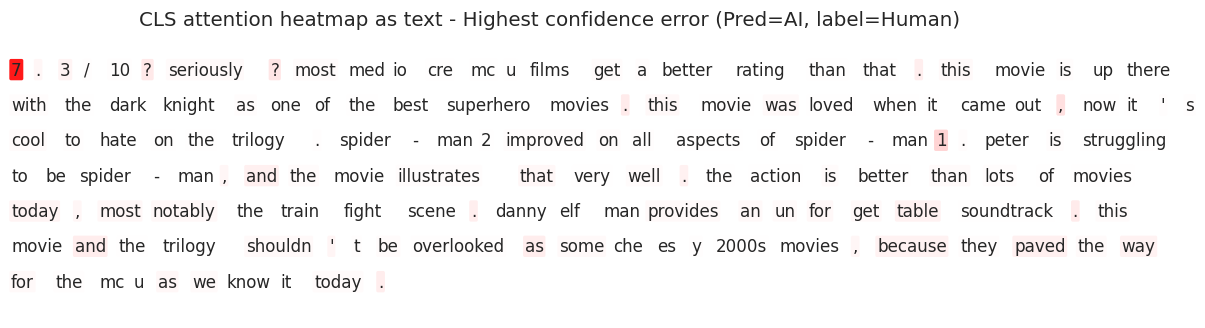

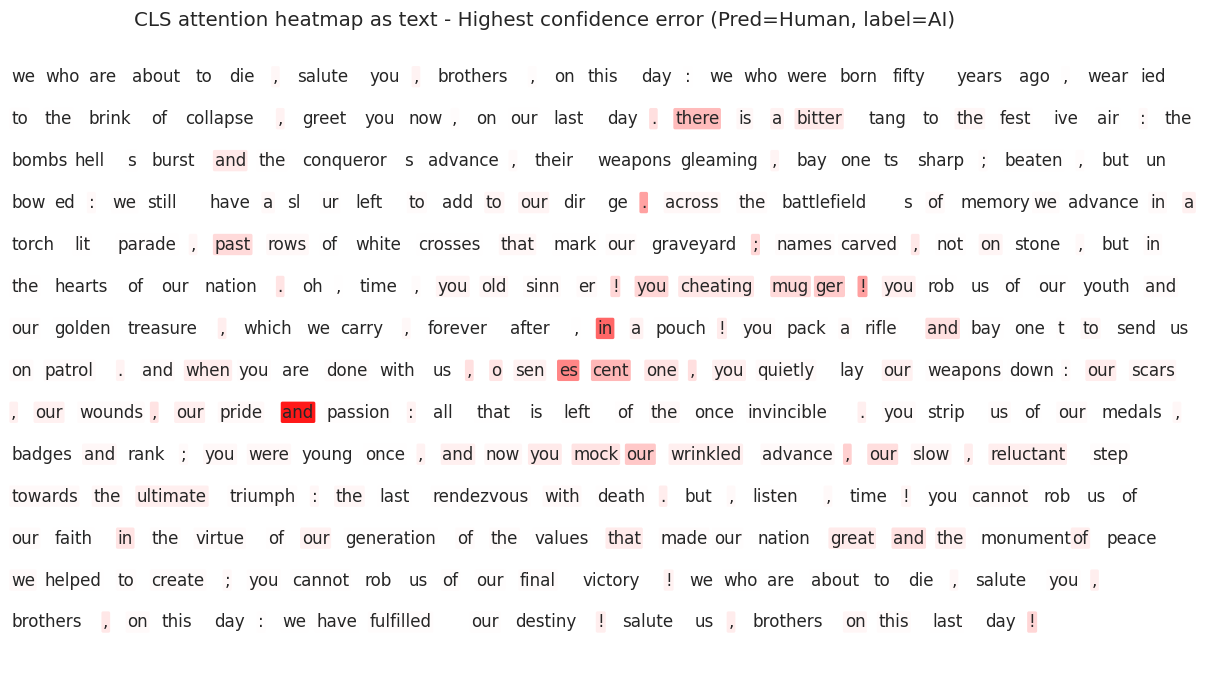

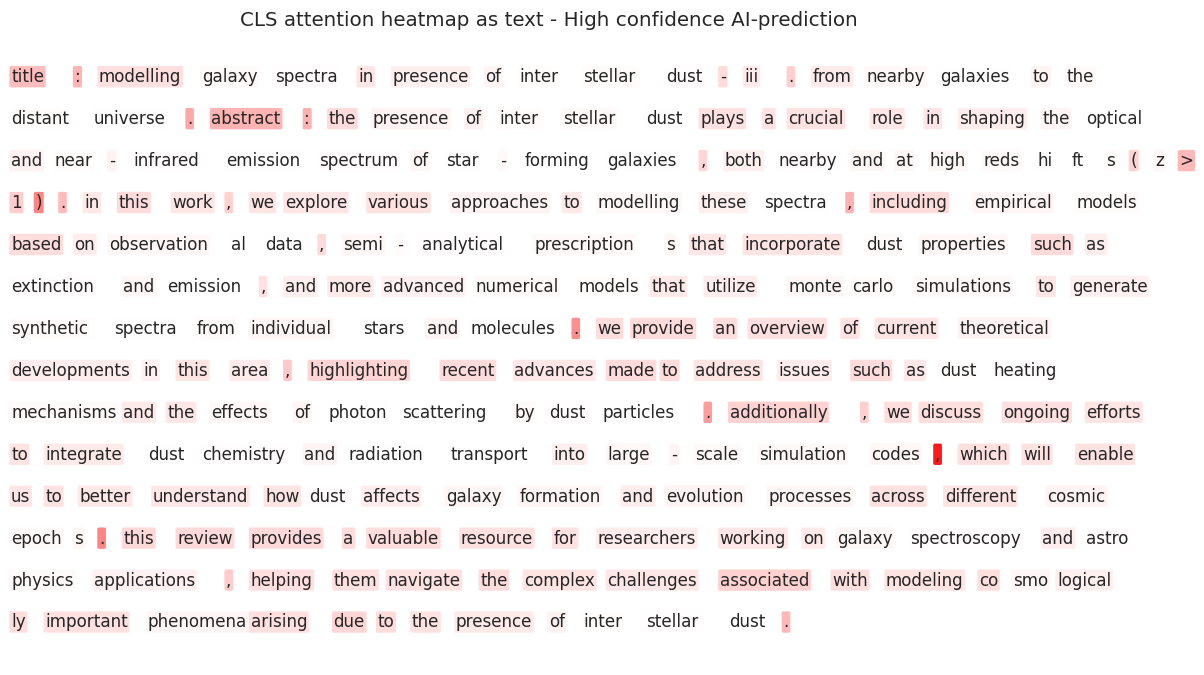

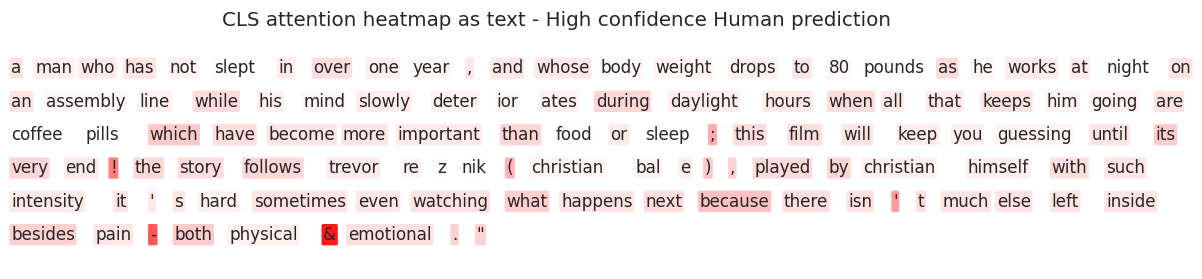

In [49]:
error_sample = analysis_df[analysis_df["error_type"] != "Correct"].copy().sort_values("prob", ascending=False).iloc[0]
print_attention_text(error_sample.name, f"Highest confidence error (Pred={error_sample['pred_name']}, label={error_sample['label_name']})")  # Highest confidence error
error_sample2 = analysis_df[analysis_df["error_type"] != "Correct"].copy().sort_values("prob", ascending=True).iloc[0]
print_attention_text(error_sample2.name, f"Highest confidence error (Pred={error_sample2['pred_name']}, label={error_sample2['label_name']})")  # Highest confidence error
print_attention_text(int(np.argmax(analysis_df["prob"])), "High confidence AI-prediction")  # Highest confidence high
print_attention_text(int(np.argmin(analysis_df["prob"][700:1000])), "High confidence Human prediction")  # Highest confidence low

In [21]:
def print_attention_heatmap(sample_idx: int):
    sample_text = analysis_df.loc[sample_idx, "text"]
    inputs = tokenizer(sample_text, return_tensors="pt", truncation=True, max_length=MAX_LENGTH)
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
    with torch.no_grad():
        attn_outputs = model(**inputs, output_attentions=True)
    attn = attn_outputs.attentions[-1].mean(dim=1).squeeze(0).cpu().numpy()  # (seq_len, seq_len)
    seq_len = min(40, attn.shape[0])
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][:seq_len])
    plt.figure(figsize=(8, 6))
    sns.heatmap(attn[:seq_len, :seq_len], cmap="magma", xticklabels=tokens, yticklabels=tokens)
    plt.title(f"Last-layer attention (sample idx {sample_idx})")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Attention to only the CLS token
    cls_row = attn[0, :seq_len]
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][:seq_len])
    plt.figure(figsize=(10, 2.5))
    plt.bar(range(seq_len), cls_row, color="darkslateblue")
    print(tokens)
    plt.xticks(range(seq_len), tokens, rotation=90)
    plt.ylabel("Attention weight")
    plt.title("CLS attention toward each token (final layer)")
    plt.tight_layout()
    plt.show()



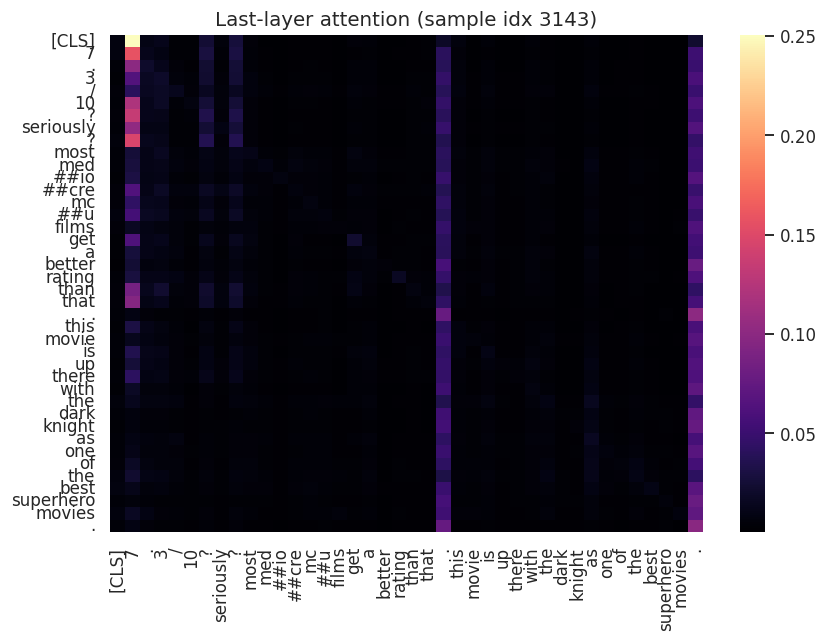

['[CLS]', '7', '.', '3', '/', '10', '?', 'seriously', '?', 'most', 'med', '##io', '##cre', 'mc', '##u', 'films', 'get', 'a', 'better', 'rating', 'than', 'that', '.', 'this', 'movie', 'is', 'up', 'there', 'with', 'the', 'dark', 'knight', 'as', 'one', 'of', 'the', 'best', 'superhero', 'movies', '.']


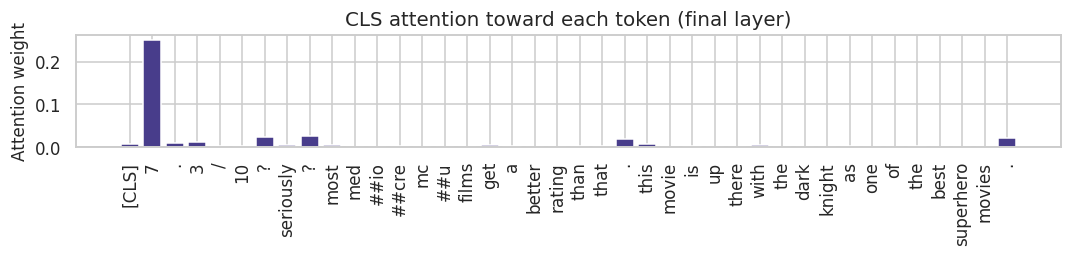

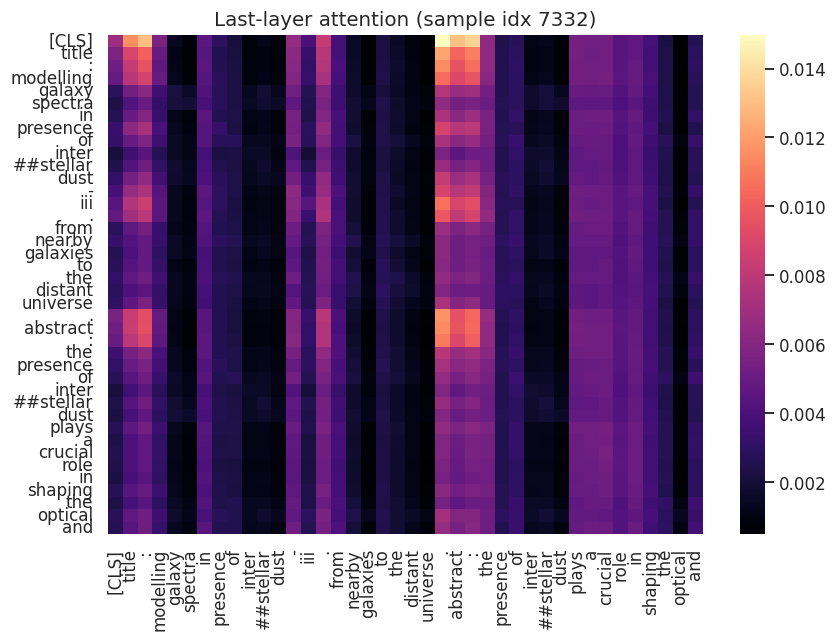

['[CLS]', 'title', ':', 'modelling', 'galaxy', 'spectra', 'in', 'presence', 'of', 'inter', '##stellar', 'dust', '-', 'iii', '.', 'from', 'nearby', 'galaxies', 'to', 'the', 'distant', 'universe', '.', 'abstract', ':', 'the', 'presence', 'of', 'inter', '##stellar', 'dust', 'plays', 'a', 'crucial', 'role', 'in', 'shaping', 'the', 'optical', 'and']


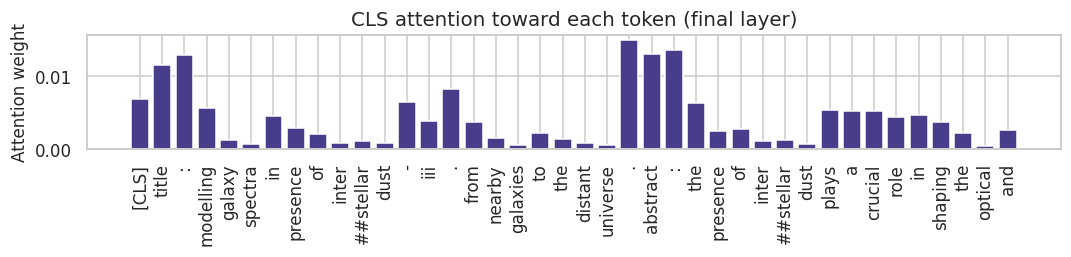

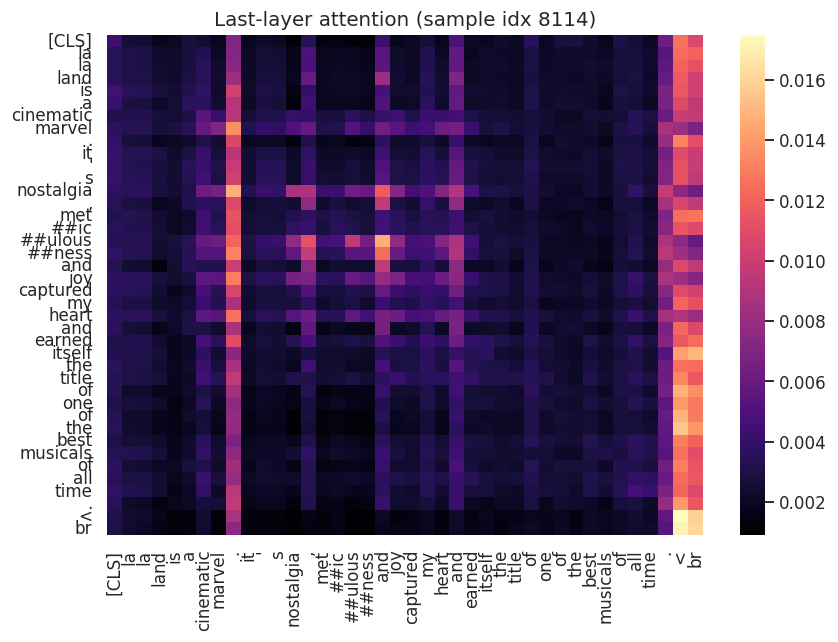

['[CLS]', 'la', 'la', 'land', 'is', 'a', 'cinematic', 'marvel', '.', 'it', "'", 's', 'nostalgia', ',', 'met', '##ic', '##ulous', '##ness', 'and', 'joy', 'captured', 'my', 'heart', 'and', 'earned', 'itself', 'the', 'title', 'of', 'one', 'of', 'the', 'best', 'musicals', 'of', 'all', 'time', '.', '<', 'br']


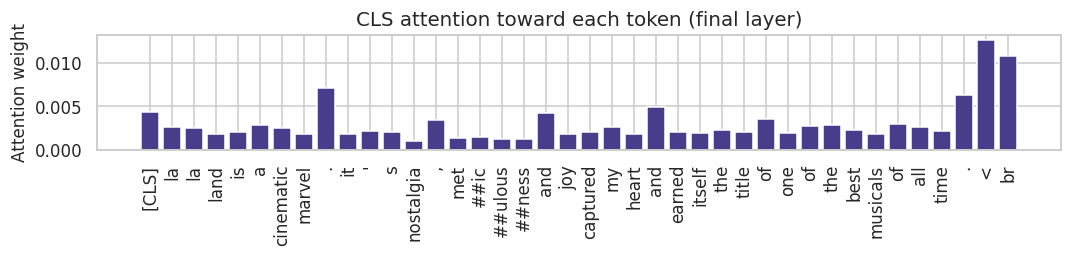

In [22]:
print_attention_heatmap(3143)  # Highest confidence error
print_attention_heatmap(int(np.argmax(analysis_df["prob"])))  # Highest confidence high
print_attention_heatmap(int(np.argmin(analysis_df["prob"])))  # Highest confidence low

## 10. Layer-wise activation norms

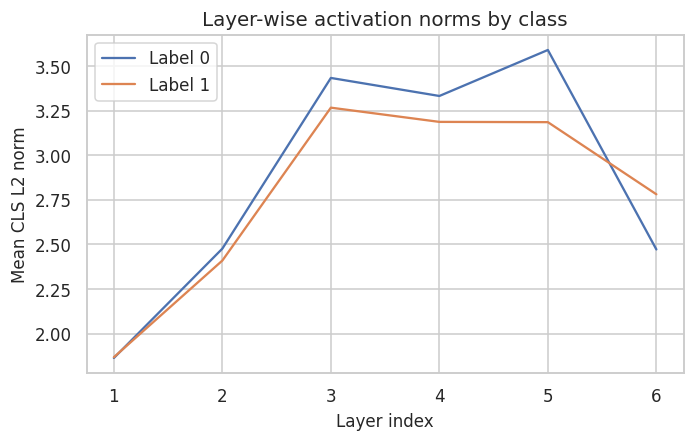

In [23]:
layer_means = {label: layer_norm_sums[label] / max(layer_counts[label], 1) for label in layer_norm_sums}
plt.figure(figsize=(7, 4))
for label, values in layer_means.items():
    plt.plot(range(1, num_layers + 1), values, label=f"Label {label}")
plt.xlabel("Layer index")
plt.ylabel("Mean CLS L2 norm")
plt.title("Layer-wise activation norms by class")
plt.legend()
plt.show()


## 11. Domain confusion analysis

In [24]:
if "model" in analysis_df.columns:
    confusion_by_gen = analysis_df.groupby("model")["error_type"].value_counts(normalize=True).unstack().fillna(0)
    display(confusion_by_gen.head())
else:
    print("Model metadata unavailable.")

error_type,Correct,False Negative,False Positive
model,,,
chatgpt,1.000000,0.000000,0.0
cohere,0.989474,0.010526,0.0
cohere-chat,1.000000,0.000000,0.0
gpt2,0.998138,0.001862,0.0
gpt3,1.000000,0.000000,0.0


## 12. Compare with perplexity classifier

`torch_dtype` is deprecated! Use `dtype` instead!


/home/erikhbj/Documents/tdt13/TDT13_AI_text_prediction/.venv/lib/python3.11/site-packages/rich/live.py:256: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

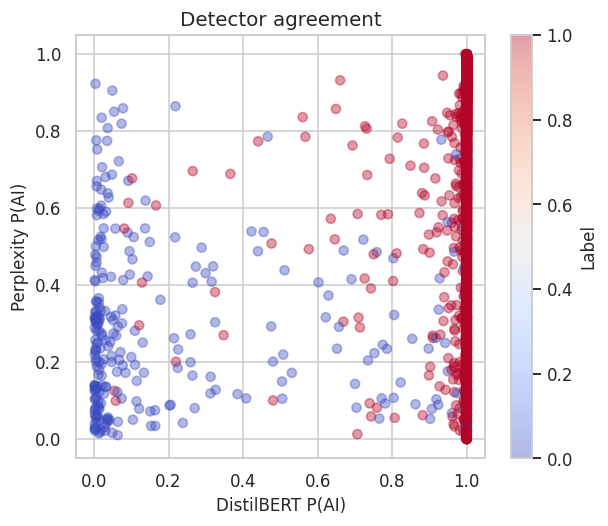

Correlation between detectors: 0.238


In [25]:
perplexity_classifier = PerplexityLogisticClassifier.load(PPL_CLASSIFIER_PATH)
preds_ppl, probs_ppl, *_ = perplexity_classifier.predict(analysis_df["text"].tolist(), return_nnl_features=True)
analysis_df["perplexity_prob"] = probs_ppl
plt.figure(figsize=(6, 5))
plt.scatter(analysis_df["prob"], analysis_df["perplexity_prob"], c=analysis_df["label"], cmap="coolwarm", alpha=0.4)
plt.xlabel("DistilBERT P(AI)")
plt.ylabel("Perplexity P(AI)")
plt.title("Detector agreement")
plt.colorbar(label="Label")
plt.show()

corr = np.corrcoef(analysis_df["prob"], analysis_df["perplexity_prob"])[0, 1]
print(f"Correlation between detectors: {corr:.3f}")


## 13. Saliency stability under word dropout

In [26]:
def drop_every_nth(text: str, n: int = 7) -> str:
    tokens = text.split()
    if len(tokens) <= n:
        return text
    kept = [tok for idx, tok in enumerate(tokens) if (idx + 1) % n != 0]
    return " ".join(kept) if kept else text

sample_idx = errors.index[0] if not errors.empty else 0
orig_text = analysis_df.loc[sample_idx, "text"]
pert_text = drop_every_nth(orig_text)
encoded = tokenizer([orig_text, pert_text], padding=True, truncation=True, max_length=MAX_LENGTH, return_tensors="pt")
encoded = {k: v.to(DEVICE) for k, v in encoded.items()}
with torch.no_grad():
    out = model(**encoded)
probs_pair = torch.softmax(out.logits, dim=-1)[:, 1].cpu().numpy()
print(f"Original prob: {probs_pair[0]:.3f} | Perturbed prob: {probs_pair[1]:.3f}")
print("Perturbed text snippet:", textwrap.fill(pert_text, width=100))


Original prob: 0.476 | Perturbed prob: 0.047
Perturbed text snippet: The Conservatives have detailed their proposals abolishing and reforming parts of the sector in
their election manifesto. They scrapping the "unelected" Equalities and Human Commission and the
Commission for Social Inspection. Shadow education secretary Michael Gove other quangos would be cut
down size. He said quangos had "grown topsy and we need now to them in". The Tories have said of all
expenditure on the public would be cut by 2015. The has also said it will ensure no public body is
exempt from 5% pay freeze that was introduced public sector workers last year. Mr said 191 different
quangos spent a total of £100bn a year on money. He told Channel 4's News Ten that the Equalities
and Human Commission would be replaced with what called a "strengthened" Equalities Bill. Similarly,
Commission for Social Care Inspection would scrapped in favour of new powers social workers to
intervene with families. Gove said those t

In [27]:
analysis_df

,id,adv_source_id,source_id,model,decoding,repetition_penalty,attack,domain,title,prompt,...,logit,prob,pred,pred_name,error_type,token_count,avg_word_len,type_token_ratio,digit_ratio,perplexity_prob
0,2df8825a-2356-4b55-8ded-b246c31a5c92,2df8825a-2356-4b55-8ded-b246c31a5c92,4a9beaa2-84f5-498b-92d9-935107c550b0,chatgpt,greedy,no,none,books,Personal Injuries,Write the body of a plot summary for a novel t...,...,6.332073,0.999991,1,AI,Correct,260,5.079070,0.674419,0.000000,0.701587
1,56ddff7a-532b-4c56-858f-cd4a27b62695,56ddff7a-532b-4c56-858f-cd4a27b62695,25fef5f2-90c7-4f9c-9cfb-6caff6c69359,llama-chat,greedy,no,none,reddit,WMR constantly goes into sleep mode even when ...,"Write just the body of a Reddit post titled ""W...",...,6.328466,0.999992,1,AI,Correct,161,4.868421,0.745614,0.000000,0.837293
2,762ecae0-9a0e-4207-a217-01da39451e60,762ecae0-9a0e-4207-a217-01da39451e60,ff71deab-4af9-4712-9a32-c46477997857,mpt,sampling,yes,none,poetry,Rudyard Kipling Parody Writers Real Mirror Ref...,The following is the full text of a poem title...,...,6.343088,0.999991,1,AI,Correct,488,5.888041,0.974555,0.000000,0.926511
3,0bdf2ff9-b0c8-447b-8177-d1a686dc3782,0bdf2ff9-b0c8-447b-8177-d1a686dc3782,87fb4135-4456-4276-bfdc-05ee75825a27,gpt2,sampling,no,none,books,Arundhati,The following is the full text of a plot summa...,...,6.126586,0.999990,1,AI,Correct,482,4.767045,0.590909,0.002841,0.585637
4,e47640bf-74e4-4c7a-8071-fd8012da79c8,e47640bf-74e4-4c7a-8071-fd8012da79c8,c568b816-b63e-4969-9a57-99d4c072e0b6,mistral,greedy,no,none,abstracts,WAYLA - Generating Images from Eye Movements,The following is the full text of the abstract...,...,6.331082,0.999992,1,AI,Correct,452,4.725067,0.183288,0.000000,0.922349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9355,306b52a2-fbbc-4b39-adce-66a292a30a60,306b52a2-fbbc-4b39-adce-66a292a30a60,aa1c2b75-2d7a-4ded-87c0-3f22ba2ad9e0,llama-chat,sampling,yes,none,wiki,Gusmiati Suid,"Write the body of a Wikipedia article titled ""...",...,6.405952,0.999993,1,AI,Correct,394,5.136223,0.616099,0.006192,0.688108
9356,0ef23c20-b13d-4667-967e-923323c5ce25,0ef23c20-b13d-4667-967e-923323c5ce25,c474d834-c241-4360-ac79-7be597587bd9,mistral,greedy,yes,none,books,Politics,The following is the full text of a plot summa...,...,6.301871,0.999992,1,AI,Correct,149,4.840336,0.865546,0.000000,0.480832
9357,653ea0db-8a6b-4c6a-882f-3f4b32d19d52,653ea0db-8a6b-4c6a-882f-3f4b32d19d52,9fa95073-196c-413e-a61f-e4579f055895,gpt4,sampling,no,none,books,The Bed And Breakfast Star,Write the body of a plot summary for a novel t...,...,5.687742,0.999976,1,AI,Correct,338,5.037879,0.643939,0.000000,0.222584
9358,802e7b6b-1f9b-4ada-adf8-6080af376a26,802e7b6b-1f9b-4ada-adf8-6080af376a26,dfc9e064-477d-43af-b3ab-e1412bb80198,cohere,sampling,no,none,recipes,Vanilla Cream Scones,The following is the full text of a recipe for...,...,6.423112,0.999993,1,AI,Correct,227,4.695652,0.683230,0.086957,0.845942


In [30]:
analysis_df.columns

Index(['id', 'adv_source_id', 'source_id', 'model', 'decoding',
       'repetition_penalty', 'attack', 'domain', 'title', 'prompt',
       'generation', 'text', 'label', 'label_name', 'char_len', 'logit',
       'prob', 'pred', 'pred_name', 'error_type', 'token_count',
       'avg_word_len', 'type_token_ratio', 'digit_ratio', 'perplexity_prob'],
      dtype='object')

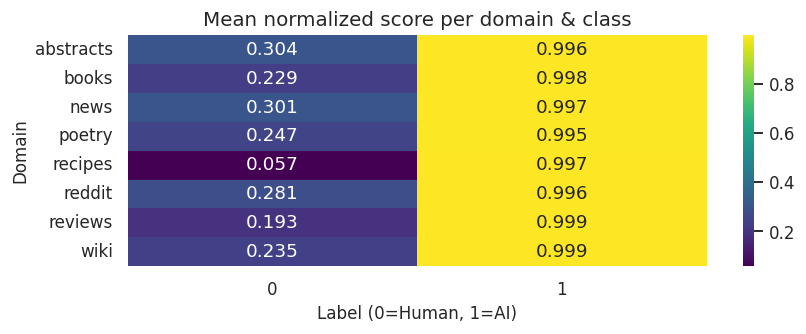

In [33]:
if "domain" not in analysis_df.columns:
    print("Domain column unavailable; skipping heatmap.")
else:
    domain_stats = (
        analysis_df.groupby(["domain", "label"])["prob"]
        .mean()
        .rename("mean_score")
        .reset_index()
    )
    pivot = domain_stats.pivot(index="domain", columns="label", values="mean_score")
    plt.figure(figsize=(8, max(3, 0.4 * len(pivot))))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
    plt.title("Mean normalized score per domain & class")
    plt.xlabel("Label (0=Human, 1=AI)")
    plt.ylabel("Domain")
    plt.tight_layout()
    plt.show()